# How to test and evaluate LLMs for SQL generation

LLMs are fundamentatlly non-deterministic in their responses, this attribute makes them wonderfully creative and dynamic in their responses. However, this trait poses significant challenges in achieving consistency, a crucial aspect for integrating LLMs into production environments.

The key to harnessing the potential of LLMs in practical applications lies in consistent and systematic evaluation. This enables the identification and rectification of inconsistencies and helps in monitoring progress over time as the application evolves.

## Scope of this notebook

This notebook aims to demonstrate a framework for evaluating LLMs, particularly focusing on:

* **Unit Testing:** Essential for assessing individual components of the application.
* **Evaluation Metrics:** Methods to quantitatively measure the model's effectiveness.
* **Runbook Documentation:** A record of historical evaluations to track progress and regression.

This example focuses on a natural language to SQL use case - code generation use cases fit well with this approach when you combine **code validation** with **code execution**, so your application can test code for real as it is generated to ensure consistency.

Although this notebook uses SQL generation usecase to demonstrate the concept, the approach is generic and can be applied to a wide variety of LLM driven applications.

We will use two versions of a prompt to perform SQL generation.  We will then use the unit tests and evaluation functions to test the perforamance of the prompts.  Specifically, in this demonstration, we will evaluate:

1. The consistency of JSON response.
2. Syntactic correctness of SQL in response.


## Table of contents

1. **[Setup](#Setup):** Install required libraries, download data consisting of SQL queries and corresponding natural language translations.
2. **[Test Development](#Test-development):** Create unit tests and define evaluation metrics for the SQL generation process.
4. **[Evaluation](#Evaluation):** Conduct tests using different prompts to assess the impact on performance.
5. **[Reporting](#Report):** Compile a report that succinctly presents the performance differences observed across various tests.

## Setup

Import our libraries and the dataset we'll use, which is the natural language to SQL [b-mc2/sql-create-context](https://huggingface.co/datasets/b-mc2/sql-create-context) dataset from HuggingFace.

In [1]:
from datasets import load_dataset
from openai import OpenAI
import pandas as pd
import pydantic
import os
import sqlite3
from sqlite3 import Error
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

# Loads key from local .env file to setup API KEY in env variables
%reload_ext dotenv
%dotenv
    
GPT_MODEL = 'gpt-3.5-turbo'
dataset = load_dataset("b-mc2/sql-create-context")

### Looking at the dataset

We use Huggingface datasets library to download SQL create context dataset.  This dataset consists of:

1. Question, expressed in natural language
2. Answer, expressed in SQL designed to answer the question in natural language.
3. Context, expressed as a CREATE SQL statement, that describes the table that may be used to answer the question.

In our demonstration today, we will use LLM to attempt to answer the question (in natural language).  The LLM will be expected to generate a CREATE SQL statement to create a context suitable to answer the user question and a coresponding SELECT SQL query designed to answer the user question completely.

The dataset looks like this:

In [2]:
sql_df = dataset['train'].to_pandas()
sql_df.head()

,question,answer,context
0,How many heads of the departments are older th...,SELECT COUNT(*) FROM head WHERE age > 56,CREATE TABLE head (age INTEGER)
1,"List the name, born state and age of the heads...","SELECT name, born_state, age FROM head ORDER B...","CREATE TABLE head (name VARCHAR, born_state VA..."
2,"List the creation year, name and budget of eac...","SELECT creation, name, budget_in_billions FROM...","CREATE TABLE department (creation VARCHAR, nam..."
3,What are the maximum and minimum budget of the...,"SELECT MAX(budget_in_billions), MIN(budget_in_...",CREATE TABLE department (budget_in_billions IN...
4,What is the average number of employees of the...,SELECT AVG(num_employees) FROM department WHER...,CREATE TABLE department (num_employees INTEGER...



## Test development

To test to output of the LLM generations, we'll develop two unit tests and an evaluation, which will combine to give us a basic evaluation framework to grade the quality of our LLM iterations.

To re-iterate, our purpose is to measure the correctness and consistency of LLM output given our questions.

### Unit tests

Unit tests should test the most granular components of your LLM application.

For this section we'll develop unit tests to test the following:
- `test_valid_schema` will check that a parseable `create` and `select` statement are returned by the LLM.
- `test_llm_sql` will execute both the `create` and `select` statements on a `sqlite` database to ensure they are syntactically correct.

In [3]:
from pydantic import BaseModel

class LLMResponse(BaseModel):
   """This simple Class expects to receive a JSON string that can be parsed into a `create` and `select` statement."""
   create: str
   select: str

#### Prompt

For this demonstration purposes, we use a fairly simple prompt requesting GPT to generate a pair of context CREATE SQL and a answering SELECT SQL query.  We supply the natural language question as part of the prompt.  We request the response to be in JSON format, so that it can be parsed easily.

In [4]:
system_prompt = '''Translate this natural language request into a JSON object containing two SQL queries. 
The first query should be a CREATE statement for a table answering the user's request, while the second should be a SELECT query answering their question. 
This should be returned as a JSON with keys "create" and "select". 
For example:\n\n{"create": """CREATE_QUERY""","select": """SELECT_QUERY"""}"'''

pprint(system_prompt)


('Translate this natural language request into a JSON object containing two '
 'SQL queries. \n'
 'The first query should be a CREATE statement for a table answering the '
 "user's request, while the second should be a SELECT query answering their "
 'question. \n'
 'This should be returned as a JSON with keys "create" and "select". \n'
 'For example:\n'
 '\n'
 '{"create": """CREATE_QUERY""","select": """SELECT_QUERY"""}"')


In [5]:
# Compiling the system prompt and user question into message array

messages = []
messages.append({"role": "system", "content": system_prompt})
messages.append({"role":"user","content": sql_df.iloc[0]['question']})
pprint(messages)

[{'content': 'Translate this natural language request into a JSON object '
             'containing two SQL queries. \n'
             'The first query should be a CREATE statement for a table '
             "answering the user's request, while the second should be a "
             'SELECT query answering their question. \n'
             'This should be returned as a JSON with keys "create" and '
             '"select". \n'
             'For example:\n'
             '\n'
             '{"create": """CREATE_QUERY""","select": """SELECT_QUERY"""}"',
  'role': 'system'},
 {'content': 'How many heads of the departments are older than 56 ?',
  'role': 'user'}]


In [6]:
# Sending the message array to GPT, requesting a response (ensure that you have API key loaded to Env for this step)

client = OpenAI()
completion = client.chat.completions.create(model = GPT_MODEL, messages = messages)

#### Check JSON formatting

Our first simple unit test checks that the LLM response is parseable into the `LLMResponse` Pydantic class that we've defined.

We'll test that our first response passes, then create a failing example to check that the check fails. This logic will be wrapped in a simple function `test_valid_schema`.

In [7]:
# Viewing the output from  GPT

content = completion.choices[0].message.content
pprint(content)

('{"create": "CREATE TABLE departments (department_id INTEGER PRIMARY KEY, '
 'department_name TEXT, head_name TEXT, age INTEGER)", "select": "SELECT '
 'COUNT(*) FROM departments WHERE age > 56"}')


#### Validating the output schema

We expect GPT to respond with a valid SQL, we can validate this using LLMResponse base model.  `test_valid_schema` is designed to help us validate this.

In [8]:
def test_valid_schema(content):
    """Tests whether the content provided can be parsed into our Pydantic model."""
    try:
        LLMResponse.model_validate_json(content)
        return True
    # Catch pydantic's validation errors:
    except pydantic.ValidationError as exc:
        print(f"ERROR: Invalid schema: {exc}")
        return False

In [9]:
test_valid_schema(content)

True

#### Testing negative scenario

To simulate a scenario in which we get an invalid JSON response from GPT, we hardcode an invalid JSON as response.  We expect `test_valid_schema` function to throw an exception.

In [10]:
failing_query = 'CREATE departments, select * from departments'
test_valid_schema(failing_query)

ERROR: Invalid schema: 1 validation error for LLMResponse
  Invalid JSON: expected value at line 1 column 1 [type=json_invalid, input_value='CREATE departments, select * from departments', input_type=str]
    For further information visit https://errors.pydantic.dev/2.5/v/json_invalid


False

As expected, we get an exception thrown from the `test_valid_schema` fucntion.

### Test SQL queries

Next we'll validate the correctness of the SQL.  This test will be desined to validate:

1. The CREATE SQL returned in GPT response is syntactically correct.
2. The SELECT SQL returned in the GPT response is syntactically correct.

To achieve this, we will use a sqlite instance. We will direct the retured SQL functions to a sqlite instance.  If the SQL statements are valid, sqlite instance will accept and execute the statements; otherwise we will expect an exception to be thrown.

`create_connection` function below will setup a sqlite instance (in-memory by default) and create a connection to be used later.

In [11]:
# Set up SQLite to act as our test database
def create_connection(db_file=":memory:"):
    """create a database connection to a SQLite database"""
    try:
        conn = sqlite3.connect(db_file)
        # print(sqlite3.version)
    except Error as e:
        print(e)
        return None

    return conn

def close_connection(conn):
    """close a database connection"""
    try:
        conn.close()
    except Error as e:
        print(e)


conn = create_connection()

Next, we will create the following functions to carry out the syntactical correctness checks.


- `test_create`: Function testing if the CREATE SQL statement succeeds.
- `test_select`: Function testing if the SELECT SQL statement succeeds.
- `test_llm_sql`: Wrapper function executing the two tests above.

In [12]:
def test_select(conn, cursor, select):
    """Tests that a SQLite select query can be executed successfully."""
    try:
        print(f"Testing select query: {select}")
        cursor.execute(select)
        record = cursor.fetchall()
        print(record)

        return True

    except sqlite3.Error as error:
        print("Error while executing select query:", error)

        return False


def test_create(conn, cursor, create):
    """Tests that a SQLite create query can be executed successfully"""
    try:
        print(f"Testing create query: {create}")
        cursor.execute(create)
        conn.commit()

        return True

    except sqlite3.Error as error:
        print("Error while creating the SQLite table:", error)

        return False


def test_llm_sql(LLMResponse):
    """Runs a suite of SQLite tests"""
    try:
        conn = create_connection()
        cursor = conn.cursor()

        create_response = test_create(conn, cursor, LLMResponse.create)

        select_response = test_select(conn, cursor, LLMResponse.select)

        if conn:
            close_connection(conn)

        if create_response is not True:
            return False

        elif select_response is not True:
            return False

        else:
            return True

    except sqlite3.Error as error:
        print("Error while creating a sqlite table", error)

        return False

In [13]:
# Viewing CREATE and SELECT sqls returned by GPT

test_query = LLMResponse.model_validate_json(content)
print(f"CREATE SQL is: {test_query.create}")
print(f"SELECT SQL is: {test_query.select}")

CREATE SQL is: CREATE TABLE departments (department_id INTEGER PRIMARY KEY, department_name TEXT, head_name TEXT, age INTEGER)
SELECT SQL is: SELECT COUNT(*) FROM departments WHERE age > 56


In [14]:
# Testing the CREATE and SELECT sqls are valid (we expect this to be succesful)

test_llm_sql(test_query)

Testing create query: CREATE TABLE departments (department_id INTEGER PRIMARY KEY, department_name TEXT, head_name TEXT, age INTEGER)
Testing select query: SELECT COUNT(*) FROM departments WHERE age > 56
[(0,)]


True

In [15]:
# Again we'll perform a negative test to confirm that a failing SELECT will return an error.

test_failure_query = '{"create": "CREATE TABLE departments (id INT, name VARCHAR(255), head_of_department VARCHAR(255))", "select": "SELECT COUNT(*) FROM departments WHERE age > 56"}'
test_failure_query = LLMResponse.model_validate_json(test_failure_query)
test_llm_sql(test_failure_query)

Testing create query: CREATE TABLE departments (id INT, name VARCHAR(255), head_of_department VARCHAR(255))
Testing select query: SELECT COUNT(*) FROM departments WHERE age > 56
Error while executing select query: no such column: age


False

### Evaluation

The last component is to **evaluate** whether the generate SQL actually answers the user's question. This test will be performed by `gpt-4`, and will assess how **relevant** the produced SQL query is when compared to the initial user request.

This is a simple example which adapts an approach outlined in the [G-Eval paper](https://arxiv.org/abs/2303.16634), and tested in one of our other [cookbooks](https://github.com/openai/openai-cookbook/blob/main/examples/evaluation/How_to_eval_abstractive_summarization.ipynb).

In [16]:
EVALUATION_MODEL = "gpt-4"

EVALUATION_PROMPT_TEMPLATE = """
You will be given one summary written for an article. Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions very carefully. 
Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:

{criteria}

Evaluation Steps:

{steps}

Example:

Request:

{request}

Queries:

{queries}

Evaluation Form (scores ONLY):

- {metric_name}
"""

# Relevance

RELEVANCY_SCORE_CRITERIA = """
Relevance(1-5) - review of how relevant the produced SQL queries are to the original question. \
The queries should contain all points highlighted in the user's request. \
Annotators were instructed to penalize queries which contained redundancies and excess information.
"""

RELEVANCY_SCORE_STEPS = """
1. Read the request and the queries carefully.
2. Compare the queries to the request document and identify the main points of the request.
3. Assess how well the queries cover the main points of the request, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.
"""

In [17]:
def get_geval_score(
    criteria: str, steps: str, request: str, queries: str, metric_name: str
):
    """Given evaluation criteria and an observation, this function uses EVALUATION GPT to evaluate the observation against those criteria.
"""
    prompt = EVALUATION_PROMPT_TEMPLATE.format(
        criteria=criteria,
        steps=steps,
        request=request,
        queries=queries,
        metric_name=metric_name,
    )
    response = client.chat.completions.create(
        model=EVALUATION_MODEL,
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=5,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    return response.choices[0].message.content

In [18]:
# Test out evaluation on a few records

evaluation_results = []

for x,y in sql_df.head(3).iterrows():
    
    score = get_geval_score(RELEVANCY_SCORE_CRITERIA,RELEVANCY_SCORE_STEPS,y['question'],y['context'] + '\n' + y['answer'],'relevancy')
    
    evaluation_results.append((y['question'],y['context'] + '\n' + y['answer'],score))

In [19]:
for result in evaluation_results:
    print(f"User Question \t: {result[0]}")
    print(f"CREATE SQL Returned \t: {result[1].splitlines()[0]}")
    print(f"SELECT SQL Returned \t: {result[1].splitlines()[1]}")
    print(f"{result[2]}")
    print("*" * 20)

User Question 	: How many heads of the departments are older than 56 ?
CREATE SQL Returned 	: CREATE TABLE head (age INTEGER)
SELECT SQL Returned 	: SELECT COUNT(*) FROM head WHERE age > 56
5
********************
User Question 	: List the name, born state and age of the heads of departments ordered by age.
CREATE SQL Returned 	: CREATE TABLE head (name VARCHAR, born_state VARCHAR, age VARCHAR)
SELECT SQL Returned 	: SELECT name, born_state, age FROM head ORDER BY age
5
********************
User Question 	: List the creation year, name and budget of each department.
CREATE SQL Returned 	: CREATE TABLE department (creation VARCHAR, name VARCHAR, budget_in_billions VARCHAR)
SELECT SQL Returned 	: SELECT creation, name, budget_in_billions FROM department
5
********************


## 

## Putting it all together

We'll now test these functions in combination including our unit test and evaluations to test out two system prompts.

Each iteration of input/output and scores should be stored as a **run**. Optionally you can add GPT-4 annotation within your evaluations or as a separate step to review an entire run and highlight the reasons for errors.

For this example, the second system prompt will include an extra line of clarification, so we can assess the impact of this for both SQL validity and quality of solution.

### First run - System Prompt 1

The system under test is the first system prompt as shown below.  This `run` will generate responses for this system prompt and evaluate the responses using the functions we've created so far.

In [20]:
# Set first system prompt
system_prompt = """Translate this natural language request into a JSON object containing two SQL queries. 
The first query should be a CREATE statement for a table answering the user's request, while the second should be a SELECT query answering their question. 
This should be returned as a JSON with keys "create" and "select". 
For example:\n\n{"create": "CREATE_QUERY","select": "SELECT_QUERY"}" """

pprint(system_prompt, width = 120)

('Translate this natural language request into a JSON object containing two SQL queries. \n'
 "The first query should be a CREATE statement for a table answering the user's request, while the second should be a "
 'SELECT query answering their question. \n'
 'This should be returned as a JSON with keys "create" and "select". \n'
 'For example:\n'
 '\n'
 '{"create": "CREATE_QUERY","select": "SELECT_QUERY"}" ')


In [21]:
def get_response(system_prompt,user_message,model=GPT_MODEL):
    messages = []
    messages.append({"role": "system", "content": system_prompt})
    messages.append({"role":"user","content": user_message})
    
    response = client.chat.completions.create(model=GPT_MODEL,messages=messages,temperature=0)
    
    return response.choices[0].message.content

#### Run the tests and evaluations

The functions below, run unit test and evaluate responses

In [40]:
def execute_unit_tests(input_df,output_list,system_prompt):
    """Unit testing function that takes in a dataframe and appends test results to an output_list.
    The system prompt is configurable to allow us to test a couple with this framework."""

    for x,y in input_df.iterrows():
        model_response = get_response(system_prompt,y['question'])

        format_valid = test_valid_schema(model_response)

        try:
            test_query = LLMResponse.model_validate_json(model_response)
            sql_valid = test_llm_sql(test_query)

        except:
            sql_valid = False

        output_list.append((y['question'],model_response,format_valid,sql_valid))
        
def evaluate_row(row):
    """Simple evaluation function to categorize unit testing results. 
    If the format or SQL are flagged it returns a label, otherwise it is correct"""
    if row['format'] == False:
        return 'Format incorrect'
    
    elif row['sql'] == False:
        return 'SQL incorrect'
    
    else:
        return 'SQL correct'

In [23]:
# Select 100 unseen queries to test this one
test_df = sql_df.tail(50)

In [24]:
# Execute unit tests and capture results
results = []

execute_unit_tests(input_df=test_df,output_list=results,system_prompt=system_prompt)

Testing create query: CREATE TABLE partnerships (id INT, player1 VARCHAR(255), player2 VARCHAR(255), venue VARCHAR(255))
Testing select query: SELECT venue FROM partnerships WHERE player1 = 'shoaib malik' AND player2 = 'misbah-ul-haq'
[]
Testing create query: CREATE TABLE partnerships (id INT, player1 VARCHAR(255), player2 VARCHAR(255), venue VARCHAR(255))
Testing select query: SELECT venue FROM partnerships WHERE player1 = 'herschelle gibbs' AND player2 = 'justin kemp'
[]
Testing create query: CREATE TABLE Played (Number INT, Points INT)
Testing select query: SELECT * FROM Played WHERE Points = 310
[]
Testing create query: CREATE TABLE losing_bonus (bonus_id INT, points_against INT)
Testing select query: SELECT * FROM losing_bonus WHERE points_against = 588
[]
Testing create query: CREATE TABLE rugby_teams (team_name VARCHAR(255), tries_against INT, losing_bonus INT);
Testing select query: SELECT * FROM rugby_teams WHERE tries_against = 7;
[]
Testing create query: CREATE TABLE try_bon

#### Run Evaluation

Now that we have generated the SQL based on system prompt 1 (run 1), we can run evaluation against the results.  We use pandas `apply` functin to "apply" evaluation to each resulting generation

In [25]:
results_df = pd.DataFrame(results)
results_df.columns = ['question','response','format','sql']

# Execute evaluation
results_df['evaluation_score'] = results_df.apply(lambda x: get_geval_score(RELEVANCY_SCORE_CRITERIA,RELEVANCY_SCORE_STEPS,x['question'],x['response'],'relevancy'),axis=1)
results_df['unit_test_evaluation'] = results_df.apply(lambda x: evaluate_row(x),axis=1)

## Viewing unit test results and evaluations - Run 1

We can now group the outcomes of the unit test (which test the structure of response) and evaluation (which checks if the SQL is syntatically correct).

In [26]:
results_df['unit_test_evaluation'].value_counts()

unit_test_evaluation
correct          46
SQL incorrect     4
Name: count, dtype: int64

In [27]:
results_df['evaluation_score'].value_counts()

evaluation_score
5    46
4     3
3     1
Name: count, dtype: int64

### Second run

We now use a new system prompt to run same unit test and evaluation.  Please note that we are using the same functions for unit testing and evaluations; the only change is the system prompt (which is under the test).

In [28]:
system_prompt_2 = """Translate this natural language request into a JSON object containing two SQL queries. 
The first query should be a CREATE statement for a table answering the user's request, while the second should be a SELECT query answering their question. 
This should be returned as a JSON with keys "create" and "select". 
For example:\n\n{"create": "CREATE_QUERY","select": "SELECT_QUERY"}" 
Ensure the SQL is always generated on one line, never use \n to separate rows."""

pprint(system_prompt_2, width=120)

('Translate this natural language request into a JSON object containing two SQL queries. \n'
 "The first query should be a CREATE statement for a table answering the user's request, while the second should be a "
 'SELECT query answering their question. \n'
 'This should be returned as a JSON with keys "create" and "select". \n'
 'For example:\n'
 '\n'
 '{"create": "CREATE_QUERY","select": "SELECT_QUERY"}" \n'
 'Ensure the SQL is always generated on one line, never use \n'
 ' to separate rows.')


In [29]:
# Execute unit tests
results_2 = []

execute_unit_tests(input_df=test_df,output_list=results_2,system_prompt=system_prompt_2)

Testing create query: CREATE TABLE partnerships (id INT, player1 VARCHAR(255), player2 VARCHAR(255), venue VARCHAR(255))
Testing select query: SELECT venue FROM partnerships WHERE player1 = 'shoaib malik' AND player2 = 'misbah-ul-haq'
[]
Testing create query: CREATE TABLE partnerships (partnership_id INT, player1 VARCHAR(255), player2 VARCHAR(255), venue VARCHAR(255));
Testing select query: SELECT venue FROM partnerships WHERE player1 = 'herschelle gibbs' AND player2 = 'justin kemp';
[]
Testing create query: CREATE TABLE scores (NumberPlayed INT, Points INT);
Testing select query: SELECT NumberPlayed FROM scores WHERE Points = 310;
[]
Testing create query: CREATE TABLE losing_bonus (bonus_id INT, points_against INT)
Testing select query: SELECT * FROM losing_bonus WHERE points_against = 588
[]
Testing create query: CREATE TABLE rugby_teams (team_name VARCHAR(255), tries_against INT, losing_bonus INT);
Testing select query: SELECT * FROM rugby_teams WHERE tries_against = 7;
[]
Testing c

In [30]:
results_2_df = pd.DataFrame(results_2)
results_2_df.columns = ['question','response','format','sql']

# Execute evaluation
results_2_df['evaluation_score'] = results_2_df.apply(lambda x: get_geval_score(RELEVANCY_SCORE_CRITERIA,RELEVANCY_SCORE_STEPS,x['question'],x['response'],'relevancy'),axis=1)
results_2_df['unit_test_evaluation'] = results_2_df.apply(lambda x: evaluate_row(x),axis=1)

## Viewing unit test results and evaluations - Run 2

We can now group the outcomes of the unit test (which test the structure of response) and evaluation (which checks if the SQL is syntatically correct).

In [31]:
results_2_df['unit_test_evaluation'].value_counts()

unit_test_evaluation
correct          43
SQL incorrect     7
Name: count, dtype: int64

In [32]:
results_2_df['evaluation_score'].value_counts()

evaluation_score
5    46
4     3
3     1
Name: count, dtype: int64

## Report

We'll make a simple dataframe to store and display the run performance - this is where you can use tools like Weights & Biases Prompts or Gantry to store the results for analytics on your different iterations.

In [33]:
results_df['run'] = 1
results_df['Evaluating Model'] = 'gpt-4'

results_2_df['run'] = 2
results_2_df['Evaluating Model'] = 'gpt-4'

In [34]:
run_df = pd.concat([results_df,results_2_df])

In [35]:
run_df.head()

,question,response,format,sql,evaluation_score,unit_test_evaluation,run,Evaluating Model
0,What venue did the parntership of shoaib malik...,"{""create"": ""CREATE TABLE partnerships (id INT,...",True,True,5,correct,1,gpt-4
1,What venue did the partnership of herschelle g...,"{""create"": ""CREATE TABLE partnerships (id INT,...",True,True,5,correct,1,gpt-4
2,What is the number Played that has 310 Points ...,"{""create"": ""CREATE TABLE Played (Number INT, P...",True,True,5,correct,1,gpt-4
3,What Losing bonus has a Points against of 588?,"{""create"": ""CREATE TABLE losing_bonus (bonus_i...",True,True,5,correct,1,gpt-4
4,What Tries against has a Losing bonus of 7?,"{""create"": ""CREATE TABLE rugby_teams (team_nam...",True,True,3,correct,1,gpt-4


In [36]:
# Unit test results
unittest_df_pivot = pd.pivot_table(run_df,  values='format',index=['run','unit_test_evaluation'], #columns='position',
                          aggfunc='count')
unittest_df_pivot.columns = ['Number of records']
unittest_df_pivot

Number of records
run unit_test_evaluation                   
1   SQL incorrect                         4
    correct                              46
2   SQL incorrect                         7
    correct                              43

#### Plotting the results

We can create a simple bar chart to visualise the results of unit tests for both runs.

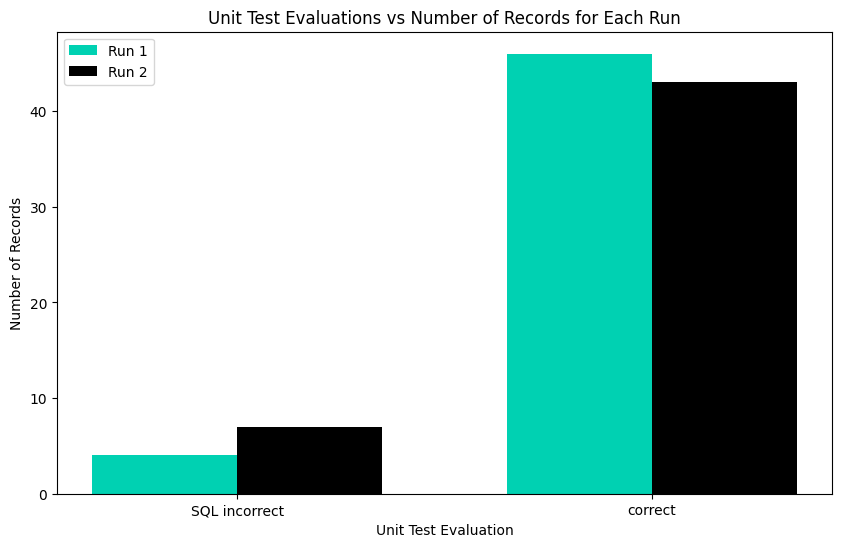

In [37]:
unittest_df_pivot.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# OpenAI brand colors
openai_colors = ['#00D1B2', '#000000']  # Green and Black

# Get unique runs and unit test evaluations
unique_runs = unittest_df_pivot['run'].unique()
unique_unit_test_evaluations = unittest_df_pivot['unit_test_evaluation'].unique()

# Ensure we have enough colors (repeating the pattern if necessary)
colors = openai_colors * (len(unique_runs) // len(openai_colors) + 1)

# Iterate over each run to plot
for i, run in enumerate(unique_runs):
    run_data = unittest_df_pivot[unittest_df_pivot['run'] == run]

    # Position of bars for this run
    positions = np.arange(len(unique_unit_test_evaluations)) + i * bar_width

    plt.bar(positions, run_data['Number of records'], width=bar_width, label=f'Run {run}', color=colors[i])

# Setting the x-axis labels to be the unit test evaluations, centered under the groups
plt.xticks(np.arange(len(unique_unit_test_evaluations)) + bar_width / 2, unique_unit_test_evaluations)

plt.xlabel('Unit Test Evaluation')
plt.ylabel('Number of Records')
plt.title('Unit Test Evaluations vs Number of Records for Each Run')
plt.legend()
plt.show()

In [38]:
# Unit test results
evaluation_df_pivot = pd.pivot_table(run_df,  values='format',index=['run','evaluation_score'], #columns='position',
                          aggfunc='count')
evaluation_df_pivot.columns = ['Number of records']
evaluation_df_pivot

Number of records
run evaluation_score                   
1   3                                 1
    4                                 3
    5                                46
2   3                                 1
    4                                 3
    5                                46

#### Plotting the results

We can create a simple bar chart to visualise the results of unit tests for both runs.

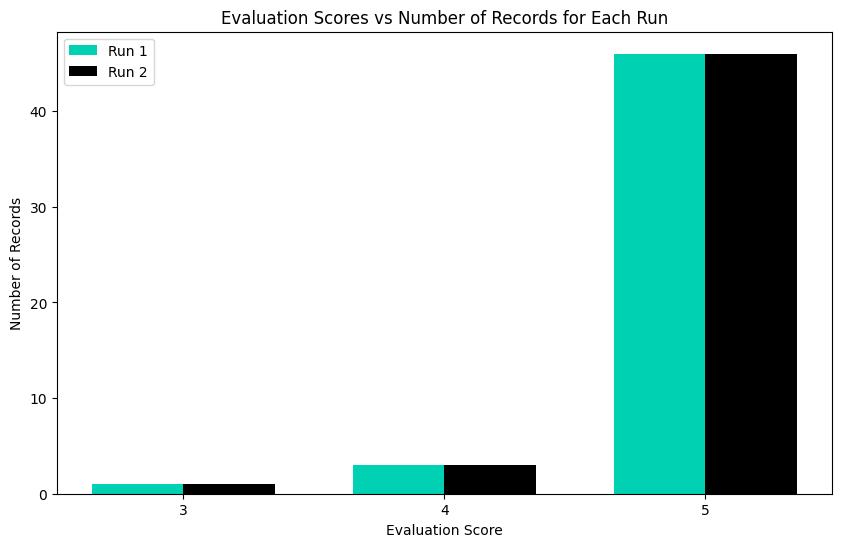

In [39]:
evaluation_df_pivot.reset_index(inplace=True)

# Plotting
plt.figure(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# OpenAI brand colors
openai_colors = ['#00D1B2', '#000000']  # Green and Black

# Get unique runs and evaluation scores
unique_runs = evaluation_df_pivot['run'].unique()
unique_evaluation_scores = evaluation_df_pivot['evaluation_score'].unique()

# Ensure we have enough colors (repeating the pattern if necessary)
colors = openai_colors * (len(unique_runs) // len(openai_colors) + 1)

# Iterate over each run to plot
for i, run in enumerate(unique_runs):
    run_data = evaluation_df_pivot[evaluation_df_pivot['run'] == run]

    # Position of bars for this run
    positions = np.arange(len(unique_evaluation_scores)) + i * bar_width

    plt.bar(positions, run_data['Number of records'], width=bar_width, label=f'Run {run}', color=colors[i])

# Setting the x-axis labels to be the evaluation scores, centered under the groups
plt.xticks(np.arange(len(unique_evaluation_scores)) + bar_width / 2, unique_evaluation_scores)

plt.xlabel('Evaluation Score')
plt.ylabel('Number of Records')
plt.title('Evaluation Scores vs Number of Records for Each Run')
plt.legend()
plt.show()

## Conclusion

Now you have a framework to test SQL generation using LLMs, and with some tweaks this approach can be extended to many other code generation use cases. With GPT-4 and engaged human labellers you can aim to automate the evaluation of these test cases, making an iterative loop where new examples are added to the test set and this structure detects any performance regressions. 

We hope you find this useful, and please supply any feedback.